In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Dropout,
    Conv1D, MaxPooling1D, LSTM, concatenate
)
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [ ]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [ ]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

In [ ]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [ ]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/Colab Notebooks/machine-learning-practice/Machine-Learning-Programming/week10/data/UCI HAR/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/Colab Notebooks/machine-learning-practice/Machine-Learning-Programming/week10/data/UCI HAR/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


In [ ]:
## 데이터 스케일링

# 1. Scaler 객체 생성
scaler = StandardScaler()

# 2. 3D 데이터를 2D로 변환 (samples * timesteps, features)
# (7352, 128, 9) -> (941056, 9)
n_samples_train, n_timesteps, n_features = trainX.shape
trainX_reshaped = trainX.reshape(-1, n_features)

# 3. train 데이터로 scaler를 'fit' (통계 계산) 및 'transform' (스케일링)
trainX_scaled_reshaped = scaler.fit_transform(trainX_reshaped)

# 4. 스케일링된 2D 데이터를 다시 3D로 변환
trainX = trainX_scaled_reshaped.reshape(n_samples_train, n_timesteps, n_features)

# 5. testX도 2D로 변환 (fit 없이 transform만 적용)
n_samples_test = testX.shape[0]
testX_reshaped = testX.reshape(-1, n_features)

# 6. 'fit' 없이 'transform'만 적용 (중요: train 데이터의 통계 사용)
testX_scaled_reshaped = scaler.transform(testX_reshaped)

# 7. testX를 다시 3D로 변환
testX = testX_scaled_reshaped.reshape(n_samples_test, n_timesteps, n_features)

In [ ]:
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [ ]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [ ]:
# 입력 레이어
inputs = Input(shape=(n_timesteps, n_features))

## Level_1
conv1 = Conv1D(filters=128, kernel_size=3, activation='relu')(inputs)
pool1 = MaxPooling1D(pool_size=5)(conv1)

## Level_2
conv2 = Conv1D(filters=64, kernel_size=3, activation='relu')(pool1)
pool2 = MaxPooling1D(pool_size=5)(conv2)

## Level_3
conv3 = Conv1D(filters=32, kernel_size=3, activation='relu')(pool2)
# pool_size를 5에서 2로 변경하여 (None, 2, 32) 입력을 (None, 1, 32)로 만듭니다.
pool3 = MaxPooling1D(pool_size=2)(conv3)

# Flatten 및 Dense 레이어
flat_cnn = Flatten()(pool3)
dense = Dense(512, activation='relu')(flat_cnn)
outputs = Dense(n_outputs, activation='softmax')(dense)

## MODEL
cnn_model_sequential = Model(inputs, outputs)

cnn_model_sequential.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model_sequential.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 126, 128)       │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 23, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 2, 32)          │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,374 (212.40 KB)

 Trainable params: 54,374 (212.40 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_history = cnn_model_sequential.fit(
    x=X_train,
    y=y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6888 - loss: 0.8109 - val_accuracy: 0.9491 - val_loss: 0.1072
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9506 - loss: 0.1093 - val_accuracy: 0.9559 - val_loss: 0.1058
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9578 - loss: 0.0973 - val_accuracy: 0.9559 - val_loss: 0.1230
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9501 - loss: 0.1177 - val_accuracy: 0.9406 - val_loss: 0.1480
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9536 - loss: 0.1119 - val_accuracy: 0.9491 - val_loss: 0.0984
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9628 - loss: 0.0850 - val_accuracy: 0.9559 - val_loss: 0.0917
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9620 - loss: 0.0825 - val_accuracy: 0.9491 - val_loss: 0.1034
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9620 - loss: 0.0842 - val_accuracy:

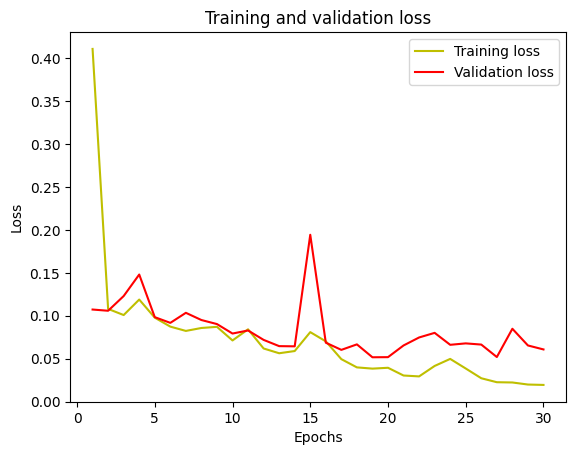

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

loss =model_history.history['loss']
val_loss =model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

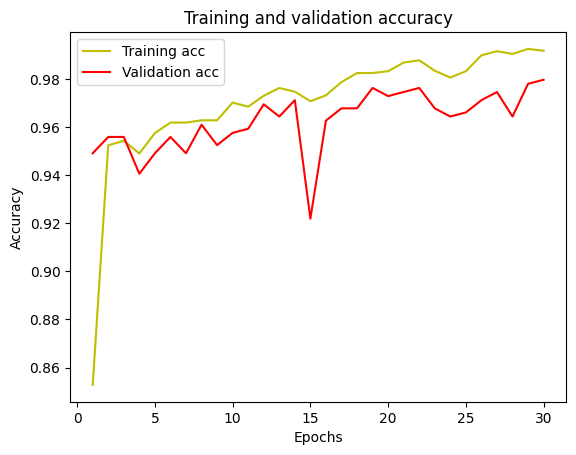

In [ ]:
acc =model_history.history['accuracy']
val_acc =model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[474   8  14   0   0   0]
 [  0 437  34   0   0   0]
 [  0   5 415   0   0   0]
 [  0   2   0 382 107   0]
 [  0   1   0  24 507   0]
 [  0   0   0   0   0 537]]
0.9338310145911096
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       496
           1       0.96      0.93      0.95       471
           2       0.90      0.99      0.94       420
           3       0.94      0.78      0.85       491
           4       0.83      0.95      0.88       532
           5       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.94      0.93      0.93      2947
weighted avg       0.94      0.93      0.93      2947



<Axes: >

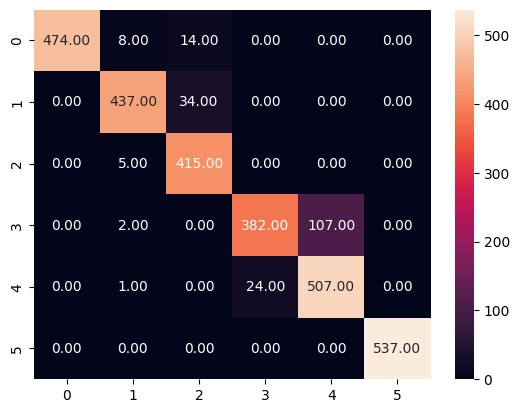

In [ ]:
pred = cnn_model_sequential.predict(testX)

pred = np.argmax(pred, axis=-1)
cm = confusion_matrix(testy, pred)
print(cm)
print(accuracy_score(testy, pred))
print(classification_report(testy, pred))
sns.heatmap(cm, annot=True, fmt='.2f')